In [1]:
import torch

Here is our RNN. We have already seen the forward method in the last blog post. Putting together this class is straightforward, the only point which requires some care is to wrap the parameters that we want to be trainable in a *torch.nn.Parameter* instance so that PyTorch registers them as parameters.

In [2]:
class RNN(torch.nn.Module):

  def __init__(self, d_in, d_hidden):
    super().__init__()
    self._d_hidden = d_hidden
    self._d_in = d_in
    self._w_ih = torch.nn.Parameter(torch.randn((d_hidden, d_in)))
    self._b_ih = torch.nn.Parameter(torch.randn(d_hidden))
    self._w_hh = torch.nn.Parameter(torch.randn((d_hidden, d_hidden)))
    self._b_hh = torch.nn.Parameter(torch.randn(d_hidden))

  def forward(self, x, h = None):
    L = x.shape[0]
    device = self._w_ih.device
    if h is None:
        h = torch.zeros(self._d_hidden).to(device)
    out = []
    for t in range(L):
      h = torch.tanh(x[t] @ self._w_ih.t() + self._b_ih + h @ self._w_hh.t() + self._b_hh)
      out.append(h)
    return torch.stack(out), h

To have a full model, we still need to add a linear layer on top of the RNN which converts the data back from the hidden dimension into the dimension corresponding to the vocabulary. So our full model will consist of an RNN layer followed by a linear layer. As usual, the final softmax is not included but will be taken care of in the loss function.

In [3]:
class MyModel(torch.nn.Module):

  def __init__(self, d_in, d_hidden):
    self._d_hidden = d_hidden
    self._d_in = d_in
    super().__init__()
    self._rnn = RNN(d_in = d_in, d_hidden = d_hidden)
    self._linear = torch.nn.Linear(in_features = d_hidden, out_features = d_in)

  def forward(self, x, h = None):
    rnn_out, hidden = self._rnn(x, h)
    out = self._linear(rnn_out)
    return out, hidden  

  

Next we need a dataset. The dataset actually implements the teacher forcing. Specifically, given an input sequence which is simply a short sequence of consecutive numbers, we form the corresponding sequence of targets by shifting the inputs to the rights. If, for instance, the inputs are [0,1,2,3,4], the corresponding target is [1,2,3,4,5].

In [4]:
class CounterDataSet(torch.utils.data.Dataset):

  def __init__(self, V, L):
    super().__init__()
    self._V = V
    self._L = L

  def __getitem__(self, index):
    if not index < len(self):
      raise KeyError
    #
    # Input at index is the sequence of length L 
    # starting at index
    #
    inputs = torch.arange(index, index + self._L, dtype = torch.long)
    targets = torch.arange(index + 1, index + self._L + 1, dtype = torch.long)
    inputs = torch.nn.functional.one_hot(inputs, num_classes = self._V)
    inputs = inputs.to(torch.float32)
    return inputs, targets

  def __len__(self):
    return self._V - self._L


Let us try this out. We create a dataset with a small value of V that still allows for visual inspection and print the first item. We see that the input (which uses one-hot encoding) represents the sequence [0,1,2,3], whereas the corresponding targets are [1,2,3,4]

In [5]:
ds = CounterDataSet(V = 10, L = 4)
#
# Print first item
#
x, y = ds[0]
print(x)
print(y)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([1, 2, 3, 4])


To be able to train our model, we still need a bit of boilerplate code. The collate function will be used to assemble a set of items into a batch. Note that we use the second dimension as the batch dimension. In the training function, we need to keep in mind that the output of the model will be of shape (L,B,V) whereas the targets (which are the labels only) have shape (L,B). To be able to feed this into the loss function, we reshape the inputs and targets to have dimensions (L x B, V) and (L x B), which is what the loss function expects.

Of course our data set is very small and the network will simply memorize all training samples. Our training run is very short and should only take a few seconds, even on a CPU.

In [6]:
def collate_fn(list):
    X = []
    Y = []
    for index, [x, y] in enumerate(list):
        Y.append(y)
        X.append(x)
    #
    # Stack along batch dimension
    #        
    X = torch.stack(X, dim = 1)
    Y = torch.stack(Y, dim = 1)
    return X, Y 

loader = torch.utils.data.DataLoader(ds, batch_size = 2, shuffle = False, collate_fn = collate_fn)
iter = loader.__iter__()
x, y = next(iter)
#
# Inputs are of dimension (L, B, V)
# Targets are of dimension (L, B)
#
print(x.shape)
print(y.shape)
print(x[:,0,:])
print(y[:,0])

torch.Size([4, 2, 10])
torch.Size([4, 2])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([1, 2, 3, 4])


Using device cuda
Completed epoch 0, mean loss in epoch is 5.031903982162476
Completed epoch 1, mean loss in epoch is 4.265012502670288
Completed epoch 2, mean loss in epoch is 3.661891222000122
Completed epoch 3, mean loss in epoch is 3.156039237976074
Completed epoch 4, mean loss in epoch is 2.5882041454315186
Completed epoch 5, mean loss in epoch is 2.059745967388153
Completed epoch 6, mean loss in epoch is 1.6740940809249878
Completed epoch 7, mean loss in epoch is 1.3834737539291382
Completed epoch 8, mean loss in epoch is 1.0943578481674194
Completed epoch 9, mean loss in epoch is 0.8986490070819855
Completed epoch 10, mean loss in epoch is 0.7310616374015808
Completed epoch 11, mean loss in epoch is 0.5889627039432526
Completed epoch 12, mean loss in epoch is 0.4809870719909668
Completed epoch 13, mean loss in epoch is 0.3724600821733475
Completed epoch 14, mean loss in epoch is 0.29757340252399445
Completed epoch 15, mean loss in epoch is 0.2355877086520195
Completed epoch 16, 

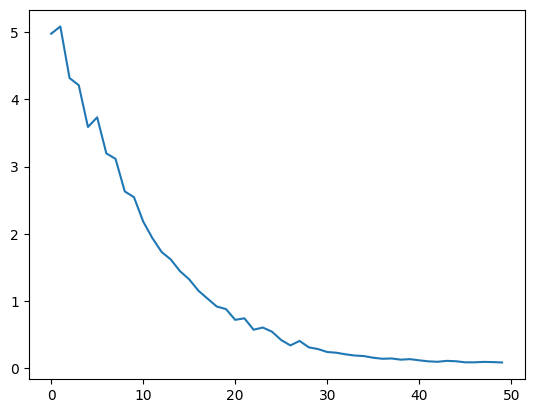

In [7]:
def train(model, epochs, train_data_loader, lr = 0.025, device = "cpu", loss_fn = torch.nn.functional.cross_entropy):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    lr_lambda = lambda epoch: (epochs - epoch) / epochs
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda, verbose = False)
    for epoch in range(epochs):
        epoch_loss = 0
        items_in_epoch = 0
        for X, Y in train_data_loader:
            items_in_epoch = items_in_epoch + 1
            f, hidden = model(X.to(device))
            targets = Y.to(device)
            #
            # f is the model output and has shape (L, B, V)
            # targets are the targets and have shape (L, B) 
            # so we first flatten them
            #
            V = f.shape[2]
            f = f.view(-1, V)
            targets = targets.flatten()
            loss = loss_fn(f, targets)            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            epoch_loss = epoch_loss + loss.item()

        epoch_loss = epoch_loss / items_in_epoch
        print(f"Completed epoch {epoch}, mean loss in epoch is {epoch_loss}")
        scheduler.step()

    return losses

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")
V = 128
L = 6
D_HIDDEN = 32
model = MyModel(d_in = V, d_hidden = D_HIDDEN)
model = model.to(device)
ds = CounterDataSet(V = V, L = L)
BATCH_SIZE = len(ds) // 2

training_data = torch.utils.data.DataLoader(ds, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_fn, drop_last = True)
losses = train(model, lr=0.1, epochs=25, train_data_loader = training_data, device = device)

import matplotlib.pyplot as plt
plt.plot(losses)  

Finally we sample from the model. We use the sequence 7,8,9,10 as prompt and do of course expect that the model correctly predicts 11 as the next value.

In [8]:
#
# Input is the sequence [7,8,9,10]
#
input = torch.arange(7, 11, dtype=torch.long)
print(input)
input = torch.nn.functional.one_hot(input, num_classes = V)
input = input.to(torch.float32)
out, hidden = model(input.to(device))
#
# Output has shape (L, V) 
# Strip off last output and apply softmax
# to obtain a probability distribution p of length V
#
p = torch.softmax(out[-1], dim = -1)
#
# Predict
#
guess = torch.argmax(p).item()
print(guess)

tensor([ 7,  8,  9, 10])
11


In [9]:
#
# Predict next value, reusing the hidden layer
#
input = torch.tensor([11], dtype=torch.long)
input = torch.nn.functional.one_hot(input, num_classes = V).to(torch.float32)
out, _ = model(input.to(device), hidden)

p = torch.softmax(out[-1], dim = -1)
guess = torch.argmax(p).item()
print(guess)

12
